Calculate the detsys errors for nue and numu. All detsys errors here are done together, as they are totally different to the nominal samples, and the varience from them calculated. This can then be added back in with the state errors in batch plot construction. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
isRun3 = False
#combine these later as with the usual systematic variations
isCombined = True

#ending = "Sept19"
ending = "Jan19"

isTruth = True

In [3]:
#https://docs.google.com/spreadsheets/d/1-4S0Ts2Lr6MkIo2FE9Mov6FeuZQ-q-qyNKQTLD7TApw/edit#gid=0
#Files are from here - New_run3 and New Run1 (intrinsic) and new_run1_highstats (overlay)

#These are high stats run 1
#Replace with numbers from extra stats calculation
detvar_run1_fhc = {
    "LYRayleigh": 7.60575E20, #Katrina 7.59732E20, #7.60573E20, 
    "LYDown": 7.43107E20, #Katrina 7.43109E20, 
    "SCE": 7.39879E20, #Katrina 7.39875E20, 
    "Recomb2": 7.59108E20, #Katrina 7.59105E20, 
    "WireModX": 7.64919E20, #Katrina 7.64918E20, 
    "WireModYZ": 7.53200E20, #Katrina 7.532E20, 
    "WireModThetaXZ": 7.64281E20, #Katrina 7.64282E20,
    "WireModThetaYZ_withSigmaSplines": 7.64541E20, #Katrina 7.64543E20, 
    "CV": 7.59735E20 #Katrina 7.59732E20
}

#These numbers are from "Pagina1" tan, the second ones from "Run1" tab
#Replace with numbers from Run1 tab
intrinsic_detvar_run1_fhc = {
    "LYRayleigh_intrinsic": 2.38081E+22, # Katrina 2.67655E22, #2.38081E22, 
    "LYDown_intrinsic": 2.24505E22, 
    "SCE_intrinsic": 2.39023E+22,  #Katrina 2.60685E22, #2.39023E22, 
    "Recomb2_intrinsic":  2.38193E+22,  #Katrina 2.60657E22, #2.38193E22, 
    "WireModX_intrinsic":  2.38318E+22,  #Katrina 2.66184E22, #2.38318E22, 
    "WireModYZ_intrinsic": 2.38416E+22,   #Katraina 2.62256E22, #2.38416E22,
    "WireModThetaXZ_intrinsic": 2.31518E+22, #Katrina 2.65175E22, #2.31518E22, 
    "WireModThetaYZ_withSigmaSplines_intrinsic": 2.31421E+22, #Katrina 2.62256E22, #2.31421E22, 
    "CV_intrinsic": 2.37261E+22 #Katrina 2.68294E22 #2.37261E22   
}

#from New_run3
detvar_run3_rhc = {
    "LYAttenuation": 3.31177E20, #checked
    "LYRayleigh":  3.15492E20, # 2.81E20, checked
    "LYDown": 3.23381E20, #checked 2.81E20, Katrina = 3.2338E20
    "SCE": 3.33283E20, #checked
    "Recomb2": 3.29538E20, #checked. Katrina = 3.29539E20
    "WireModX": 3.24286E20, #checked
    "WireModYZ": 3.36399E20, # checked
    "WireModThetaXZ": 3.20027E20, #checked
    "WireModThetaYZ_withSigmaSplines": 3.35762E20, #checked
    "CV": 2.87218E20 #checked. 2.72E20 Katrina = 2.87219E20
    
}

intrinsic_detvar_run3_rhc = {
    "LYAttenuation_intrinsic": 2.54177E+22, #2.54177E+22 - checked. Katrina - 2.5392E22
    "LYRayleigh_intrinsic": 2.53581E22,   #checked
    "LYDown_intrinsic": 2.53082E22, #checked
    "SCE_intrinsic": 2.54153E22,   #Checked
    "Recomb2_intrinsic": 2.54549E22,  #Checked
    "WireModX_intrinsic": 2.50092E22, #checked
    "WireModYZ_intrinsic": 2.54089E22,   #checked
    "WireModThetaXZ_intrinsic": 2.44365E22, #checked
    "WireModThetaYZ_withSigmaSplines_intrinsic":2.5992E22, #checked
    "CV_intrinsic": 2.5392E22   #Checked
    
}


In [4]:
if isRun3 == False and isCombined == False:
    standard_dict = detvar_run1_fhc
    intrinsic_dict = intrinsic_detvar_run1_fhc

    run = 'run1'
    detvar = detvar_run1_fhc
elif isRun3 == True and isCombined == False:
    standard_dict = detvar_run3_rhc
    intrinsic_dict = intrinsic_detvar_run3_rhc

    run = 'run3'
    detvar = detvar_run3_rhc
elif isCombined == True:
    standard_dict_run1 = detvar_run1_fhc
    intrinsic_dict_run1 = intrinsic_detvar_run1_fhc
    run_run1 = 'run1'
    detvar_run1 = detvar_run1_fhc
    standard_dict_run3 = detvar_run3_rhc
    intrinsic_dict_run3 = intrinsic_detvar_run3_rhc
    run_run3 = 'run3'
    detvar_run3 = detvar_run3_rhc

In [5]:
variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "proton_e", "elec_e",
        "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "n_showers_contained",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v",
        #"theta", # angle between incoming and outgoing leptons in radians
        "weightSplineTimesTune", "nu_e", "true_pt","true_pt_visible","true_p",
        "true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y",
        "true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z",
        "ppfx_cv"
    ]

In [6]:
input_path = "/media/alex/TOSHIBA EXT/detSys/"

In [7]:
if isCombined == False:
    print(detvar.keys())
elif isCombined == True:
    print(detvar_run1.keys())
    print(detvar_run3.keys())

dict_keys(['LYRayleigh', 'LYDown', 'SCE', 'Recomb2', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ_withSigmaSplines', 'CV'])
dict_keys(['LYAttenuation', 'LYRayleigh', 'LYDown', 'SCE', 'Recomb2', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ_withSigmaSplines', 'CV'])


In [8]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

In [9]:
if isRun3 == False and isCombined == False:
    beamon_pot = 2e+20
elif isRun3 == True and isCombined == False:
    beamon_pot = 5.014e+20
elif isCombined == True:
    beamon_pot_run1 = 2e+20
    beamon_pot_run3 = 5.014e+20

In [10]:
#xvar = "reco_e"
#bins = np.arange(0, 5.5, 0.5)
#x_label = "Reconstructed Energy [GeV]"


if isTruth == True:
    xvar = "true_nu_vtx_x" 
    x_label = "True X Position [cm]"
else:
    xvar = "reco_nu_vtx_sce_x"
    x_label = "Reconstructed X Position [cm]"
    
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]

xlow = bins[0]
xhigh = bins[-1]

In [11]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score > 0.3"

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [12]:
if isCombined == False:
    detvar_dict = {}
elif isCombined == True:
    detvar_dict_run1 = {}
    detvar_dict_run3 = {}

In [13]:
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

In [14]:
import pandas as pandas
import time
s = time.time()

if isCombined == False:
    for variation in detvar.keys(): 

        print("Plotting", variation)

        standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run+"_overlay_"+variation+".root"
        intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run+"_overlay_"+variation+"_intrinsic.root"

        f_standard = uproot.open(standard_input_file)[fold][tree]
        f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]

        uproot_v = [f_standard, f_intrinsic]

        df_standard = f_standard.pandas.df(variables, flatten=False)
        df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)

        print("All good to here.")

        INTERCEPT = 0.0
        SLOPE = 0.83


        for i, df in enumerate([df_standard, df_intrinsic]):

            up = uproot_v[i]
            load_data_run123.process_uproot_numu(up, df)
            trk_llr_pid_v = up.array('trk_llr_pid_score_v')
            trk_id = up.array('trk_id')-1 
            trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
            df['trkpid'] = trk_llr_pid_v_sel
            df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
            df["extdata"] = np.zeros_like(df["isVtxInFiducial"])
            df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
            #df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
            #df["true_e"] = (df["elec_e"] + INTERCEPT) / SLOPE + df["proton_e"]

            df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
            df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

            # bool for is signal vs is not signal 
            df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    

            print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))

        # APPLY SW TRIGGER
        df_standard = df_standard.query('nslice==1')
        df_intrinsic = df_intrinsic.query('nslice==1')

        # POT SCALING
        df_standard['pot_scale'] = beamon_pot/standard_dict.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
        df_standard['pot_scale_dirt'] = (beamon_pot/standard_dict.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
        df_intrinsic['pot_scale'] = beamon_pot/intrinsic_dict.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 

        # remove nue CC events 
        print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
        len1 = len(df_standard)

        idx = df_standard.query(nueCC_query).index
        df_standard.drop(idx, inplace=True)
        len2 = len(df_standard) 

        print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above

        df_standard_sel = df_standard.query(NUMU_SEL_QUERY).copy()
        df_intrinsic_sel = df_intrinsic.query(NUMU_SEL_QUERY).copy()

        standard_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale'])[0]
        plt.close()

        print("non-nueCC events = ", sum(standard_counts))

        dirt_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale_dirt'])[0]
        plt.close()

        print("dirt events = ", sum(dirt_counts))

        intrinsic_counts = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]
        plt.close()


        print("nue CC events = ", sum(intrinsic_counts))


        # store counts in a dictionary 
        detvar_dict[variation] = list(standard_counts)
        detvar_dict[variation+'_intrinsic'] = list(intrinsic_counts)
        detvar_dict[variation+'_dirt'] = list(dirt_counts)
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)
#R1 approx 25 mins, R3 15

time to run:  0.0003349781036376953


In [15]:
import pandas as pandas
import time
s = time.time()

if isCombined == True:
    for variation in detvar_run1.keys(): 

        print("Plotting", variation)

        standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run_run1+"_overlay_"+variation+".root"
        intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run_run1+"_overlay_"+variation+"_intrinsic.root"

        f_standard = uproot.open(standard_input_file)[fold][tree]
        f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]

        uproot_v = [f_standard, f_intrinsic]

        df_standard = f_standard.pandas.df(variables, flatten=False)
        df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)

        print("All good to here.")

        #INTERCEPT = 0.0
        #SLOPE = 0.83



        for i, df in enumerate([df_standard, df_intrinsic]):

            up = uproot_v[i]
            load_data_run123.process_uproot_numu(up, df)
            trk_llr_pid_v = up.array('trk_llr_pid_score_v')
            trk_id = up.array('trk_id')-1 
            trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
            df['trkpid'] = trk_llr_pid_v_sel
            df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
            df["extdata"] = np.zeros_like(df["isVtxInFiducial"])
            df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
            #df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
            #df["true_e"] = (df["elec_e"] + INTERCEPT) / SLOPE + df["proton_e"]

            df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
            df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

            # bool for is signal vs is not signal 
            df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

            print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))

        # APPLY SW TRIGGER
        if isTruth==False:
            df_standard = df_standard.query('nslice==1')
            df_intrinsic = df_intrinsic.query('nslice==1')

        # POT SCALING
        df_standard['pot_scale'] = beamon_pot_run1/standard_dict_run1.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
        df_standard['pot_scale_dirt'] = (beamon_pot_run1/standard_dict_run1.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
        df_intrinsic['pot_scale'] = beamon_pot_run1/intrinsic_dict_run1.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 

        # remove nue CC events 
        print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
        len1 = len(df_standard)

        idx = df_standard.query(nueCC_query).index
        df_standard.drop(idx, inplace=True)
        len2 = len(df_standard) 

        print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above

        if isTruth==False:
            df_standard_sel_run1 = df_standard.query(NUMU_SEL_QUERY).copy()
            df_intrinsic_sel_run1 = df_intrinsic.query(NUMU_SEL_QUERY).copy()
        elif isTruth==True:
            df_standard_sel_run1 = df_standard.query('is_signal==True').copy()
            df_intrinsic_sel_run1 = df_intrinsic.query('is_signal==True').copy()

        standard_counts = plt.hist(df_standard_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1['ppfx_cv']*df_standard_sel_run1['weightSplineTimesTune']*df_standard_sel_run1['pot_scale'])[0]
        plt.close()

        print("non-nueCC events = ", sum(standard_counts))

        dirt_counts = plt.hist(df_standard_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1['ppfx_cv']*df_standard_sel_run1['weightSplineTimesTune']*df_standard_sel_run1['pot_scale_dirt'])[0]
        plt.close()

        print("dirt events = ", sum(dirt_counts))

        intrinsic_counts = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune']*df_intrinsic_sel_run1['pot_scale'])[0]
        plt.close()


        print("nue CC events = ", sum(intrinsic_counts))


        # store counts in a dictionary 
        detvar_dict_run1[variation] = list(standard_counts)
        detvar_dict_run1[variation+'_intrinsic'] = list(intrinsic_counts)
        detvar_dict_run1[variation+'_dirt'] = list(dirt_counts)
        
    ########################################################################
    for variation in detvar_run3.keys(): 

        print("Plotting", variation)

        standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run_run3+"_overlay_"+variation+".root"
        intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run_run3+"_overlay_"+variation+"_intrinsic.root"

        f_standard = uproot.open(standard_input_file)[fold][tree]
        f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]

        uproot_v = [f_standard, f_intrinsic]

        df_standard = f_standard.pandas.df(variables, flatten=False)
        df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)

        print("All good to here.")

        #INTERCEPT = 0.0
        #SLOPE = 0.83



        for i, df in enumerate([df_standard, df_intrinsic]):

            up = uproot_v[i]
            load_data_run123.process_uproot_numu(up, df)
            trk_llr_pid_v = up.array('trk_llr_pid_score_v')
            trk_id = up.array('trk_id')-1 
            trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
            df['trkpid'] = trk_llr_pid_v_sel
            df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
            df["extdata"] = np.zeros_like(df["isVtxInFiducial"])
            df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
            #df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
            #df["true_e"] = (df["elec_e"] + INTERCEPT) / SLOPE + df["proton_e"]

            df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
            df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

            # bool for is signal vs is not signal 
            df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

            print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))

        # APPLY SW TRIGGER
        if isTruth == False:
            df_standard = df_standard.query('nslice==1')
            df_intrinsic = df_intrinsic.query('nslice==1')

        # POT SCALING
        df_standard['pot_scale'] = beamon_pot_run3/standard_dict_run3.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
        df_standard['pot_scale_dirt'] = (beamon_pot_run3/standard_dict_run3.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
        df_intrinsic['pot_scale'] = beamon_pot_run3/intrinsic_dict_run3.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 

        # remove nue CC events 
        print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
        len1 = len(df_standard)

        idx = df_standard.query(nueCC_query).index
        df_standard.drop(idx, inplace=True)
        len2 = len(df_standard) 

        print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above

        if isTruth == False:
            df_standard_sel_run3 = df_standard.query(NUMU_SEL_QUERY).copy()
            df_intrinsic_sel_run3 = df_intrinsic.query(NUMU_SEL_QUERY).copy()
        elif isTruth == True:
            df_standard_sel_run3 = df_standard.query('is_signal==True').copy()
            df_intrinsic_sel_run3 = df_intrinsic.query('is_signal==True').copy()

        standard_counts = plt.hist(df_standard_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3['ppfx_cv']*df_standard_sel_run3['weightSplineTimesTune']*df_standard_sel_run3['pot_scale'])[0]
        plt.close()

        print("non-nueCC events = ", sum(standard_counts))

        dirt_counts = plt.hist(df_standard_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3['ppfx_cv']*df_standard_sel_run3['weightSplineTimesTune']*df_standard_sel_run3['pot_scale_dirt'])[0]
        plt.close()

        print("dirt events = ", sum(dirt_counts))

        intrinsic_counts = plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune']*df_intrinsic_sel_run3['pot_scale'])[0]
        plt.close()


        print("nue CC events = ", sum(intrinsic_counts))


        # store counts in a dictionary 
        detvar_dict_run3[variation] = list(standard_counts)
        detvar_dict_run3[variation+'_intrinsic'] = list(intrinsic_counts)
        detvar_dict_run3[variation+'_dirt'] = list(dirt_counts)
    
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)
#Approx 40 mins

Plotting LYRayleigh
All good to here.
trk_llr_pid_v  [[] [] [] ... [] [0.96771365 -0.05971109] []]
trk_score_v  [[] [] [] ... [] [0.999961 0.757183] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
is_signal check: True
trk_llr_pid_v  [[0.798005 0.16471732 -3.4028235e+38 0.023728557] [0.85296315 0.40649202] [0.8860264 0.63174385 0.60301065 0.55862236] ... [0.53158176 0.67946833 0.33856034 -0.12603316] [0.80966306 -0.69061345 -0.3469407] []]
trk_score_v  [[0.6925704 0.9036271 -1.0 0.65457773] [0.014536137 0.95495903] [0.00974944 0.93844473 0.0011510102 0.6660284] ... [0.99905366 0.11506345 0.55271107 0.19061932] [0.004943335 0.88983196 0.90810287] []]
updated proton mask test
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3958
# of nueCC in AV removed = 3958
non-nueCC events =  7744.438961536382
dirt events =  5808.329221152265
nue CC events =  0.0
Plotting LYDown
All good to here.
trk_llr_pid_v  [[0.98124784] [] [0.93819624 0.7752653 -0.027052782 0.055031985] ... [] [] [0.8493995]]
trk_score_v  [[0.99999946] [] [0.977496 0.87158513 0.7900027 0.7379162] ... [] [] [0.01264332]]
updated proton mask test
is_signal check: True
trk_l

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
is_signal check: True
trk_llr_pid_v  [[0.92394626 -0.8924842 0.87513995 ... 0.42951462 0.0047872835 -0.22693132] [0.83603364 0.10247985] [0.94547904 -0.4155484] ... [0.9464739 0.77884614 0.18936 0.36805388 -0.40305084] [0.78234774 0.94582784 0.025298681 0.5639784] [0.68747485 0.37095195 0.26259676]]
trk_score_v  [[0.0030616957 0.9655176 0.8918294 ... 0.043340437 0.86614865 0.9588625] [0.13417612 0.11452982] [0.009614589 0.9412469] ... [0.0103479875 0.91931105 0.1769236 0.0036317068 0.92397606] [0.0046421103 0.9867979 0.96810186 0.2417228] [0.21864146 0.5681438 0.7173643]]
updated proton mask test
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 3952
# of nueCC in AV removed = 3952
non-nueCC events =  7758.4646877917485
dirt events =  5818.848515843832
nue CC events =  0.0
Plotting WireModX
All good to here.
trk_llr_pid_v  [[] [0.88031906 0.8849418 0.6785917 0.12629017 0.07993772] [] ... [] [-0.4928708] [0.9458652]]
trk_score_v  [[] [0.

All good to here.
trk_llr_pid_v  [[] [] [] ... [] [] [-0.39294276]]
trk_score_v  [[] [] [] ... [] [] [0.9776551]]
updated proton mask test
is_signal check: True
trk_llr_pid_v  [[] [0.8978432 0.6171912 0.78816104 0.15397346] [0.9509767 0.73759717 0.47909814] ... [0.90527904 -0.018259613] [0.9481239 -0.7127815 0.55704457 0.5099538] [0.8103111 -0.56368524]]
trk_score_v  [[] [0.00705607 0.90793276 0.45117536 0.43357053] [0.99990875 0.8211042 0.86066335] ... [0.00135076 0.9401062] [0.9998637 0.8379876 0.07009545 0.090252504] [0.087204315 0.15033491]]
updated proton mask test
is_signal check: True
# nueCC in AV in standard overlay det. sys. sample = 1626
# of nueCC in AV removed = 1626
non-nueCC events =  17662.13291032641
dirt events =  13246.59968274477
nue CC events =  0.0
Plotting Recomb2
All good to here.
trk_llr_pid_v  [[] [] [] ... [] [0.9771194 0.5719452 -0.89683056] [0.96901315 0.95070434 0.76155525 0.81526184 0.6062589]]
trk_score_v  [[] [] [] ... [] [1.0 0.00032170097 0.98262453] 

In [16]:
## CV background event rate
if isCombined == False:
    x1 = plt.hist(df_standard_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel.query('is_signal==False')['ppfx_cv']*df_standard_sel.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel.query('is_signal==False')['pot_scale'])[0]

    plt.close()

    x3 = plt.hist(df_standard_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel.query('is_signal==False')['ppfx_cv']*df_standard_sel.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel.query('is_signal==False')['pot_scale_dirt'])[0]

    plt.close()

    x2 = plt.hist(df_intrinsic_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel.query('is_signal==False')['pot_scale'])[0]
    #x2 = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
    #            weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]

    plt.close()
elif isCombined == True:
    x1_run1 = plt.hist(df_standard_sel_run1.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1.query('is_signal==False')['ppfx_cv']*df_standard_sel_run1.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run1.query('is_signal==False')['pot_scale'])[0]

    plt.close()

    x3_run1 = plt.hist(df_standard_sel_run1.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1.query('is_signal==False')['ppfx_cv']*df_standard_sel_run1.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run1.query('is_signal==False')['pot_scale_dirt'])[0]

    plt.close()

    x2_run1 = plt.hist(df_intrinsic_sel_run1.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel_run1.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel_run1.query('is_signal==False')['pot_scale'])[0]
    #x2_run1 = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
    #            weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune']*df_intrinsic_sel_run1['pot_scale'])[0]

    plt.close()
    
    x1_run3 = plt.hist(df_standard_sel_run3.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3.query('is_signal==False')['ppfx_cv']*df_standard_sel_run3.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run3.query('is_signal==False')['pot_scale'])[0]

    plt.close()

    x3_run3 = plt.hist(df_standard_sel_run3.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3.query('is_signal==False')['ppfx_cv']*df_standard_sel_run3.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run3.query('is_signal==False')['pot_scale_dirt'])[0]

    plt.close()

    x2_run3 = plt.hist(df_intrinsic_sel_run3.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel_run3.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel_run3.query('is_signal==False')['pot_scale'])[0]
    #x2_run3 = plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
    #            weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune']*df_intrinsic_sel_run3['pot_scale'])[0]

    plt.close()

In [17]:
if isCombined == False:
    detvar_dict['cv_total_bkgd'] = x1+x2+x3
elif isCombined == True:
    detvar_dict_run1['cv_total_bkgd'] = list(x1_run1+x3_run1+x2_run1)
    detvar_dict_run3['cv_total_bkgd'] = list(x1_run3+x3_run3+x2_run1)

print(x2_run3)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]
bin_centers = []
for a in range(len(bins)-1): 
    bin_centers.append(round(bins[a] + (bins[a+1]-bins[a])/2, 3))

In [19]:
#background should correspond to the dirt?

if isCombined == False:
    print(detvar_dict['cv_total_bkgd'])
elif isCombined == True:
    print(detvar_dict_run1['cv_total_bkgd'])
    print(detvar_dict_run3['cv_total_bkgd'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [20]:
print(type(detvar_dict_run1))

<class 'dict'>


In [21]:
import csv

if isTruth==True:
    print("Truth")
    with open('numu_detsys_detvar_dict_cut_run1_Sept19.csv', 'w') as f:
        w = csv.DictWriter(f, detvar_dict_run1.keys())
        w.writeheader()
        w.writerow(detvar_dict_run1)


    with open('numu_detsys_detvar_dict_cut_run3_Sept19.csv', 'w') as f:
        w = csv.DictWriter(f, detvar_dict_run3.keys())
        w.writeheader()
        w.writerow(detvar_dict_run3)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


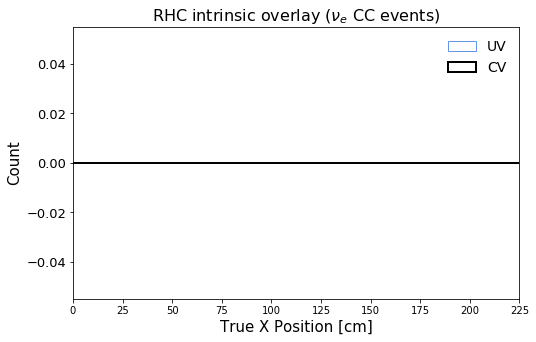

In [21]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 

if isRun3 == False and isCombined == False:
    for variation in detvar_run1_fhc.keys(): 

        if variation=='CV_intrinsic': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"],
                 linewidth=1, color='cornflowerblue')

        n+=1
elif isRun3 == True and isCombined == False:
    for variation in detvar_run3_rhc.keys(): 

        if variation=='CV_intrinsic': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_intrinsic"],
                 linewidth=1, color='cornflowerblue')

        n+=1
elif isCombined == True:
    for variation in detvar_run3_rhc.keys(): 

        if variation=='CV_intrinsic': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run3[variation+"_intrinsic"], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run3[variation+"_intrinsic"],
                 linewidth=1, color='cornflowerblue')

        n+=1


#plt.hist(bin_centers, bins, histtype='step', 
#                 weights=detvar_dict_run3['CV_intrinsic'], color='black', label='CV', linewidth=2)

current = (plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run3['CV_intrinsic'], color='black', label='CV', linewidth=2)[0])

print(current)

plt.title('RHC intrinsic overlay ($\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Count' , fontsize=15) # 2.68294E22
plt.xlabel(x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("RHC_Numu_Detsys_NueCC_Jan19.svg", bbox_inches='tight')
    
plt.show()

[1185.46984501 2140.95574975 2039.95628103 2139.01135081 1971.64609936
 2040.75207998 2013.60965191 2088.66399432 2053.72830888]


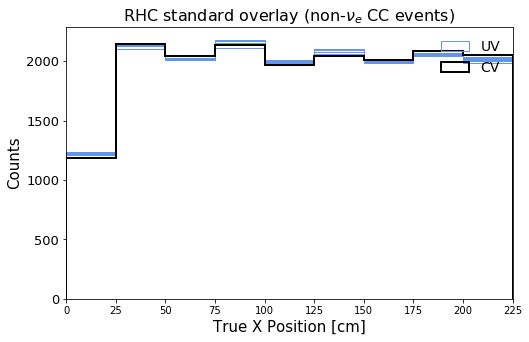

In [22]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 

if isRun3 == False and isCombined == False:
    for variation in detvar_run1_fhc.keys(): 

        if variation=='CV': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation],
                 linewidth=1, color='cornflowerblue')

        n+=1
elif isRun3 == True and isCombined == False:
    for variation in detvar_run3_rhc.keys(): 

        if variation=='CV': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation],
                 linewidth=1, color='cornflowerblue')

        n+=1
elif isCombined == True:
    for variation in detvar_run3_rhc.keys(): 

        if variation=='CV': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run3[variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run3[variation],
                 linewidth=1, color='cornflowerblue')

        n+=1

#plt.hist(bin_centers, bins, histtype='step', 
#                 weights=detvar_dict_run3['CV'], color='black', label='CV', linewidth=2)

current = plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run3['CV'], color='black', label='CV', linewidth=2)

print(current[0])


plt.title('RHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel(x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("RHC_Numu_Detsys_NonNueCC_Jan19.svg", bbox_inches='tight')
    
plt.show()

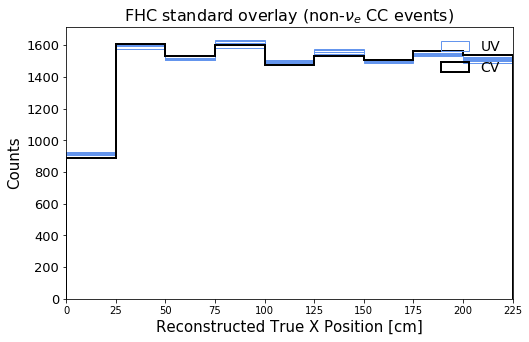

In [23]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 

if isRun3 == False and isCombined == False:
    for variation in detvar_run1_fhc.keys(): 

        if variation=='CV': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"],
                 linewidth=1, color='cornflowerblue')

        n+=1
elif isRun3 == True and isCombined == False:
    for variation in detvar_run3_rhc.keys(): 

        if variation=='CV': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict[variation+"_dirt"],
                 linewidth=1, color='cornflowerblue')

        n+=1
elif isCombined == True:
    for variation in detvar_run3_rhc.keys(): 

        if variation=='CV': 
            continue

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run3[variation+"_dirt"], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run3[variation+"_dirt"],
                 linewidth=1, color='cornflowerblue')

        n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run3['CV_dirt'], color='black', label='CV', linewidth=2)


plt.title('FHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_standard.pdf", 
#            transparent=True, bbox_inches='tight')
    
plt.show()

In [24]:
detvar_dict_run1['CV']

[539.2602176912013,
 940.8621428810505,
 904.6660554563366,
 939.7077987110915,
 897.8102684858759,
 883.0351740338556,
 889.9987455358278,
 877.2638544978108,
 884.9855567940322]

In [25]:
def calcCov(var, bins, ncv_nu, ncv_total, uni_counts, plot=False, save=False, axis_label=None, pot=None, isrun3=False, xticks=None, xhigh=None): 
    
    # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
    # ncv total is the total event rate -- (MC + EXT or estimated signal)
    # when background subtracting these two are the same  
    
    # compute the cov matrix 
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    N = len(uni_counts)
    print('number of universes = ', N)
    

    #####################################################
    
    for k in range(N): 
        
        uni = uni_counts[k]
        #print("uni = ", uni)

        for i in range(len(bins)-1): 

            cvi = ncv_nu[i]
            uvi = uni[i]
            #print("uvi = ", uvi)


            for j in range(len(bins)-1): 
                
                cvj = ncv_nu[j]
                uvj = uni[j]
        
                c = ((uvi - cvi)*(uvj - cvj)) / N

                cov[i][j] += c
                
                #print("ncv_total[i]*ncv_total[j] ", ncv_total[i]*ncv_total[j])
                #print(ncv_total[i])
                if ncv_total[i]*ncv_total[j] != 0: 
                    frac_cov[i][j] += c/(ncv_total[i]*ncv_total[j])
                    #frac_cov[i][j] = c/(ncv_total[i]*ncv_total[j])
            
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, cov, cmap='OrRd', edgecolors='k')
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)

        plt.title('Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_cov.pdf", transparent=True, bbox_inches='tight') 
            print('saving to: '+save)
        plt.show()
        
        ##################################
        # fractional covariance 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, frac_cov, cmap='OrRd', edgecolors='k')#, vmin=0, vmax=.03)
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        plt.title('Fractional Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_frac_cov.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################    
    # compute the corr matrix 

    for i in range(len(cov)): 
        for j in range(len(cov[i])): 
            
            #print(i, j, cov[i][j], cov[i][i], cov[j][j])

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
            #print(cor[i][j])
    
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))

        plt.pcolor(bins, bins, cor, cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
    

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])
            
        plt.title('Correlation Matrix', fontsize=16)
        if save: 
            plt.savefig(save+var+"_cor.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################
    
    # sys_err = [np.sqrt(x) for x in np.diagonal(cov)]
    # percent error = [y/z for y,z in zip(sys_err, ncv)] # w.r.t. to whatever event rate is being used (total or background subtracted)
        
    dictionary = {
        'cov' : cov, 
        'frac_cov' : frac_cov, 
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    }
           
    return dictionary

In [26]:
detvar_dict_run1['CV_dirt']

[404.44516326840034,
 705.646607160782,
 678.4995415922549,
 704.78084903331,
 673.3577013644226,
 662.2763805253767,
 667.4990591518722,
 657.9478908733554,
 663.7391675955614]

In [27]:
# Not background subtracting to get cov on all measurements


if isRun3 == False and isCombined == False:
    
    detsys_cov_fhc = {}
    
    for variation in detvar_run1_fhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue


        # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
        # ncv total is the total event rate -- (MC + EXT or estimated signal)
        # when background subtracting these two are the same
        # so can just add in dirt with the others

        #Background subtracting reduces the values to zero
        detsys_cov_fhc[variation] = calcCov(xvar, bins, 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [ [(a+b+d) for a,b,c,d in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'], detvar_dict[variation+"_dirt"])] ] )


        #detsys_cov_fhc[variation] = calcCov(xvar, bins, 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [ [(a+b) for a,b,c in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'])] ] )
elif isRun3 == True and isCombined == False:
    
    detsys_cov_fhc = {}
    
    for variation in detvar_run3_rhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue


        # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
        # ncv total is the total event rate -- (MC + EXT or estimated signal)
        # when background subtracting these two are the same
        # so can just add in dirt with the others

        #Background subtracting reduces the values to zero
        detsys_cov_fhc[variation] = calcCov(xvar, bins, 
                                            [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [ [(a+b+d)-c for a,b,c,d in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'], detvar_dict[variation+"_dirt"])] ] )


        #detsys_cov_fhc[variation] = calcCov(xvar, bins, 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [ [(a+b) for a,b,c in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'])] ] )
elif isCombined == True:
    
    detsys_cov_fhc_run1 = {}
    detsys_cov_fhc_run3 = {}
    
    for variation in detvar_run1_fhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue


        # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
        # ncv total is the total event rate -- (MC + EXT or estimated signal)
        # when background subtracting these two are the same

        detsys_cov_fhc_run1[variation] = calcCov(xvar, bins, 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run1['CV_intrinsic'], detvar_dict_run1['CV'], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1['CV_dirt'])], 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run1['CV_intrinsic'], detvar_dict_run1['CV'], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1['CV_dirt'])], 
                                            [ [(a+b+d) for a,b,c,d in zip(detvar_dict_run1[variation+"_intrinsic"], detvar_dict_run1[variation], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1[variation+"_dirt"])] ] )
        
        run1_CV = [(a+b+d) for a,b,c,d in zip(detvar_dict_run1['CV_intrinsic'], detvar_dict_run1['CV'], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1['CV_dirt'])]

        
    for variation in detvar_run3_rhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue

        detsys_cov_fhc_run3[variation] = calcCov(xvar, bins, 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run3['CV_intrinsic'], detvar_dict_run3['CV'], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3['CV_dirt'])], 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run3['CV_intrinsic'], detvar_dict_run3['CV'], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3['CV_dirt'])], 
                                            [ [(a+b+d) for a,b,c,d in zip(detvar_dict_run3[variation+"_intrinsic"], detvar_dict_run3[variation], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3[variation+"_dirt"])] ] )

        
        run3_CV = [(a+b+d) for a,b,c,d in zip(detvar_dict_run3['CV_intrinsic'], detvar_dict_run3['CV'], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3['CV_dirt'])]

LYRayleigh
number of universes =  1
LYDown
number of universes =  1
SCE
number of universes =  1
Recomb2
number of universes =  1
WireModX
number of universes =  1
WireModYZ
number of universes =  1
WireModThetaXZ
number of universes =  1
WireModThetaYZ_withSigmaSplines
number of universes =  1
CV
LYAttenuation
number of universes =  1
LYRayleigh
number of universes =  1
LYDown
number of universes =  1
SCE
number of universes =  1
Recomb2
number of universes =  1
WireModX
number of universes =  1
WireModYZ
number of universes =  1
WireModThetaXZ
number of universes =  1
WireModThetaYZ_withSigmaSplines
number of universes =  1
CV


In [28]:
detsys_cov_fhc_run3

{'LYAttenuation': {'cov': [[6982.519334911214,
    -1745.6344916180385,
    -2271.4148466438965,
    1041.975223209085,
    3636.36124346708,
    4707.271873870018,
    -2567.975167013465,
    -4397.524745224182,
    -7847.206035013886],
   [-1745.6344916180385,
    436.40978738017554,
    567.8552268735394,
    -260.49450088179543,
    -909.0927366060647,
    -1176.8211085885184,
    641.995504795018,
    1099.3841198013336,
    1961.8067434578252],
   [-2271.4148466438965,
    567.8552268735394,
    738.8916747797188,
    -338.9547351482268,
    -1182.9089931587869,
    -1531.2764216833418,
    835.3628025064957,
    1430.515622755971,
    2552.697592040505],
   [1041.975223209085,
    -260.49450088179543,
    -338.9547351482268,
    155.49006221196916,
    542.640576644913,
    702.4485613606863,
    -383.2093216650242,
    -656.2261568060097,
    -1171.009182748685],
   [3636.36124346708,
    -909.0927366060647,
    -1182.9089931587869,
    542.640576644913,
    1893.7467207396694,

In [29]:
cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

if isCombined == False:
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
            frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])

    # compute the corr matrix 
    for i in range(len(cov)): 
        for j in range(len(cov[i])): 

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    detsys_dict = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
        'cor' : cor
    } 
elif isCombined == True:
    
    comb_CV = np.array(run1_CV) + np.array(run3_CV)
    
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            cov[i][j] = sum([detsys_cov_fhc_run1[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
            cov[i][j] += sum([detsys_cov_fhc_run3[x]['cov'][i][j] for x in detvar_run3_rhc.keys() if x is not 'CV'])
            #frac_cov[i][j] = sum([detsys_cov_fhc_run1[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
            #frac_cov[i][j] += sum([detsys_cov_fhc_run3[x]['frac_cov'][i][j] for x in detvar_run3_rhc.keys() if x is not 'CV'])
            frac_cov[i][j] = cov[i][j]/(comb_CV[i]*comb_CV[j])
            
    # compute the corr matrix 
    for i in range(len(cov)): 
        for j in range(len(cov[i])): 

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    detsys_dict_comb = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
        'cor' : cor
    }

<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:33: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_9528/3360999739.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
/tmp/ipykernel_9528/3360999739.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
/tmp/ipykernel_9528/3360999739.py:32: SyntaxWarning: "is not" with a 

In [30]:
detsys_dict_comb['fractional_uncertainty']

array([0.05994404, 0.02101694, 0.02121492, 0.01968709, 0.02601784,
       0.03818344, 0.02123961, 0.03530876, 0.04819103])

In [29]:
if isRun3 == False and isCombined == False:
    np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_frac_"+ending+".csv", 
               detsys_dict['fractional_uncertainty'],
               delimiter =", ", 
               fmt ='% s')
elif isRun3 == True and isCombined == False:
    np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_frac_run3_"+ending+".csv", 
               detsys_dict['fractional_uncertainty'],
               delimiter =", ", 
               fmt ='% s')
elif isCombined == True:
    np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_frac_comb_"+ending+".csv", 
               detsys_dict_comb['fractional_uncertainty'],
               delimiter =", ", 
               fmt ='% s')
    

In [31]:
detsys_dict_comb['cov']

[[32734.854055170876,
  -16790.275153922492,
  -16587.176558847892,
  7406.988761275559,
  21832.823689490215,
  31612.994819326697,
  -13261.736639020155,
  -30097.438139588747,
  -40236.37538507246],
 [-16790.275153922492,
  12847.81049704169,
  9385.867684823117,
  -6104.37413216265,
  -11307.754453976911,
  -19076.898289025805,
  5808.870405275984,
  17979.88328191015,
  22141.440919168603],
 [-16587.176558847892,
  9385.867684823117,
  11951.376985685805,
  -6510.0903439797175,
  -12397.789531773837,
  -18472.16912216853,
  8959.024136007525,
  18552.585294762634,
  25939.966710820947],
 [7406.988761275559,
  -6104.37413216265,
  -6510.0903439797175,
  11250.690858335414,
  4571.16672113879,
  11909.429849379401,
  -4606.817313527968,
  -9149.934429209072,
  -13197.105789558269],
 [21832.823689490215,
  -11307.754453976911,
  -12397.789531773837,
  4571.16672113879,
  17069.377439702457,
  21180.275219956668,
  -10272.610318004405,
  -22902.16247796305,
  -27988.305466154634],
 [3

In [32]:
if isCombined == False:
    detsys_err_std = np.sqrt( np.diag((detsys_dict['cov'])))
    print(detsys_err_std)
    print("")

    detsys_err = ( np.diag((detsys_dict['cov'])))
    print(detsys_err)
elif isCombined == True:
    detsys_err_std = np.sqrt( np.diag((detsys_dict_comb['cov'])))
    print(detsys_err_std)
    print("")

    detsys_err = ( np.diag((detsys_dict_comb['cov'])))
    print(detsys_err)

[180.92775922 113.34818259 109.32235355 106.06927387 130.64982755
 195.37042612 107.92513121 183.26566895 247.83439147]

[32734.85405517 12847.81049704 11951.37698569 11250.69085834
 17069.3774397  38169.60340175 11647.83394704 33586.30541675
 61421.88559388]


In [32]:
if isRun3 == False and isCombined == False:
    np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_"+ending+".csv", 
               detsys_err,
               delimiter =", ", 
               fmt ='% s')
elif isRun3 == True and isCombined == False:
    np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_run3_"+ending+".csv", 
               detsys_err,
               delimiter =", ", 
               fmt ='% s')  
elif isCombined == True:
    np.savetxt("numu_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_dirt_comb_"+ending+".csv", 
               detsys_err,
               delimiter =", ", 
               fmt ='% s')

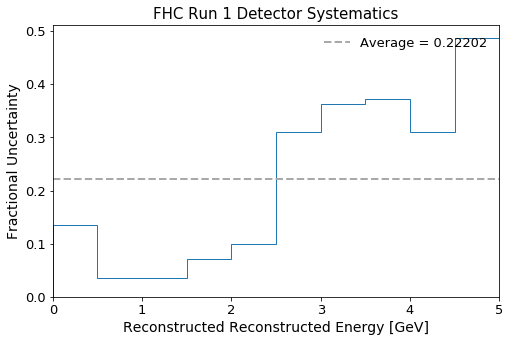

In [32]:
######################
######FHC - ENERGY############
#####################
if isRun3 == False and isCombined == False:
    x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

    plt.figure(figsize=(8, 5))

    #cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
    #cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

    plt.hist(bin_centers, bins, weights=detsys_dict['fractional_uncertainty'], histtype='step')

    plt.hlines(np.average(detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
               label='Average = '+str(round(np.average(detsys_dict['fractional_uncertainty']), 5)))

    plt.xlim(xlow, xhigh)
    #plt.xlim(0, 5)
    #plt.ylim(0, 1)

    plt.legend(fontsize=13,  frameon=False)

    plt.xlabel("Reconstructed "+x_label, fontsize=14)
    plt.ylabel("Fractional Uncertainty", fontsize=14)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.title("FHC Run 1 Detector Systematics", fontsize=15)


    plt.show()

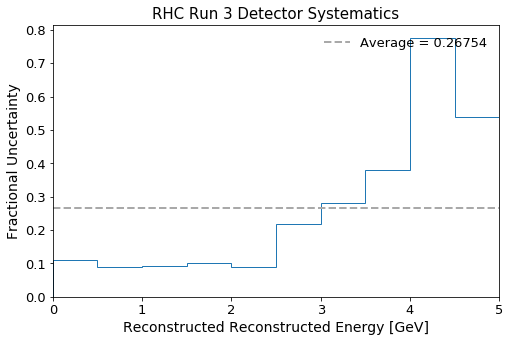

In [71]:
######################
######RHC - ENERGY############
#####################

if isRun3 == True isCombined == False:
    x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

    plt.figure(figsize=(8, 5))

    #cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
    #cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

    plt.hist(bin_centers, bins, weights=detsys_dict['fractional_uncertainty'], histtype='step')

    plt.hlines(np.average(detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
               label='Average = '+str(round(np.average(detsys_dict['fractional_uncertainty']), 5)))

    plt.xlim(xlow, xhigh)
    #plt.xlim(0, 5)
    #plt.ylim(0, 1)

    plt.legend(fontsize=13,  frameon=False)

    plt.xlabel("Reconstructed "+x_label, fontsize=14)
    plt.ylabel("Fractional Uncertainty", fontsize=14)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.title("RHC Run 3 Detector Systematics", fontsize=15)


    plt.show()

In [33]:
######################
######FHC - POS############
#####################
if isRun3 == False and isCombined == False:
    x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

    plt.figure(figsize=(8, 5))

    #cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
    #cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

    plt.hist(bin_centers, bins, weights=detsys_dict['fractional_uncertainty'], histtype='step')

    plt.hlines(np.average(detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
               label='Average = '+str(round(np.average(detsys_dict['fractional_uncertainty']), 5)))

    plt.xlim(xlow, xhigh)
    #plt.xlim(0, 5)
    #plt.ylim(0, 1)

    plt.legend(fontsize=13,  frameon=False)

    plt.xlabel("Reconstructed "+x_label, fontsize=14)
    plt.ylabel("Fractional Uncertainty", fontsize=14)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.title("FHC Run 1 Detector Systematics", fontsize=15)


    plt.show()

In [ ]:
#####################
######RHC - POS############
#####################

if isRun3 == True and isCombined == False:
    x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

    plt.figure(figsize=(8, 5))

    #cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
    #cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

    plt.hist(bin_centers, bins, weights=detsys_dict['fractional_uncertainty'], histtype='step')

    plt.hlines(np.average(detsys_dict['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
               label='Average = '+str(round(np.average(detsys_dict['fractional_uncertainty']), 5)))

    plt.xlim(xlow, xhigh)
    #plt.xlim(0, 5)
    #plt.ylim(0, 1)

    plt.legend(fontsize=13,  frameon=False)

    plt.xlabel("Reconstructed "+x_label, fontsize=14)
    plt.ylabel("Fractional Uncertainty", fontsize=14)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.title("RHC Run 3 Detector Systematics", fontsize=15)


    plt.show()

In [1]:
##################################################

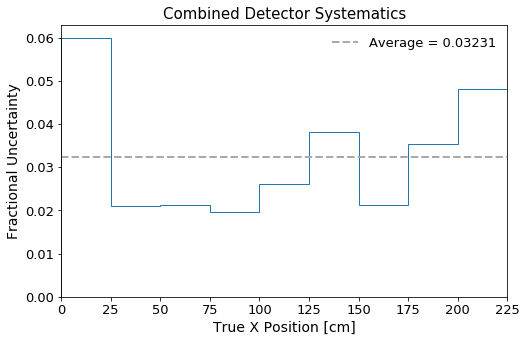

In [34]:
#####################
######COMB - POS############
#####################

if isCombined == True:
    x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

    plt.figure(figsize=(8, 5))


    plt.hist(bin_centers, bins, weights=detsys_dict_comb['fractional_uncertainty'], histtype='step')

    plt.hlines(np.average(detsys_dict_comb['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
               label='Average = '+str(round(np.average(detsys_dict_comb['fractional_uncertainty']), 5)))

    plt.xlim(xlow, xhigh)
    #plt.xlim(0, 5)
    #plt.ylim(0, 1)

    plt.legend(fontsize=13,  frameon=False)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("Fractional Uncertainty", fontsize=14)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.title("Combined Detector Systematics", fontsize=15)



### Try to recreate detsys study now

So will use reco_x for this

Intrinsic

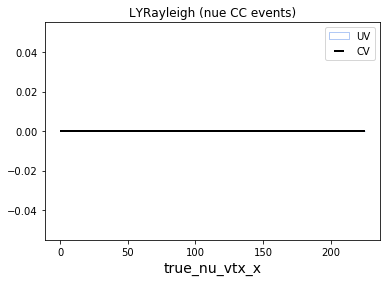

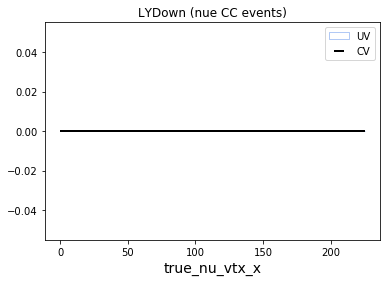

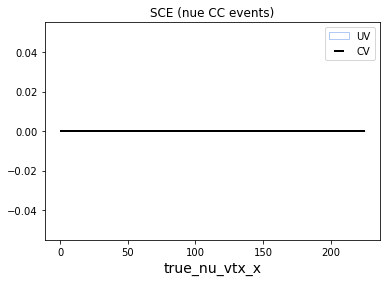

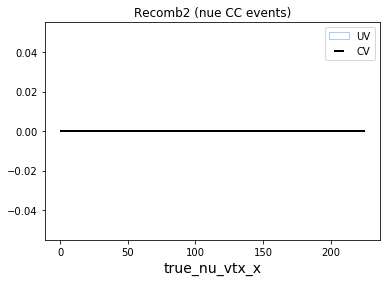

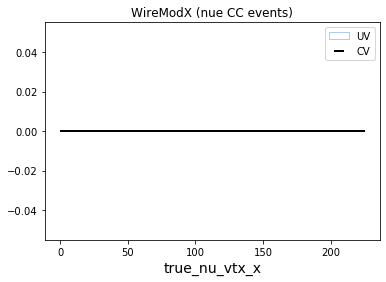

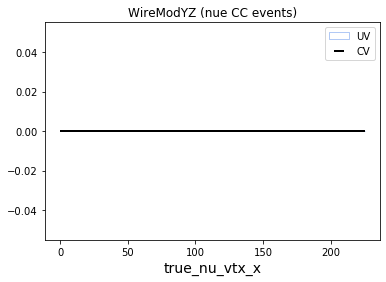

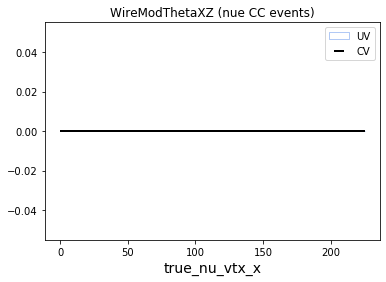

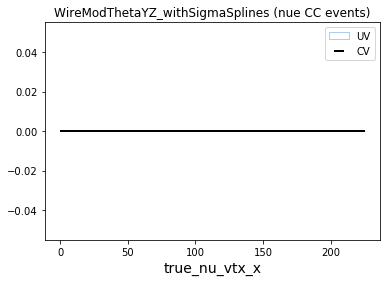

In [35]:
for variation in detvar_run1: 
    
    if variation=='CV': 
        continue
    
    plt.hist(bin_centers, bins, histtype='step', 
                        range=[bins[0], bins[-1]], weights=detvar_dict_run1[variation+'_intrinsic'], 
                        color='cornflowerblue', linewidth=0.5, label='UV')
    
    plt.errorbar(bin_centers, detvar_dict_run1['CV_intrinsic'], xerr=x_err, fmt='none', color='black', linewidth=2, label='CV')
    plt.xlabel(xvar, fontsize=14)
    #plt.ylabel('$\\nu$ / '+str(beamon_pot)+' POT', fontsize=14)
    plt.title(variation+' (nue CC events)')
    plt.legend()
    plt.show()

In [36]:
if isCombined == False:
    detsys_cov_nueCC = {}


    for variation in detvar_run1.keys(): 

        if variation=='CV': 
            continue

        detsys_cov_nueCC[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict_run1['CV_intrinsic'], 
                                                  detvar_dict_run1['CV_intrinsic'], 
                                                  [detvar_dict_run1[variation+'_intrinsic']])
elif isCombined == True:
    detsys_cov_nueCC_run1 = {}
    detsys_cov_nueCC_run3 = {}


    for variation in detvar_run1.keys(): 

        if variation=='CV': 
            continue

        detsys_cov_nueCC_run1[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict_run1['CV_intrinsic'], 
                                                  detvar_dict_run1['CV_intrinsic'], 
                                                  [detvar_dict_run1[variation+'_intrinsic']])

    run1_CV = detvar_dict_run1['CV_intrinsic']
        
    for variation in detvar_run3.keys(): 

        if variation=='CV': 
            continue

        detsys_cov_nueCC_run3[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict_run3['CV_intrinsic'], 
                                                  detvar_dict_run3['CV_intrinsic'], 
                                                  [detvar_dict_run3[variation+'_intrinsic']])

    run3_CV = detvar_dict_run3['CV_intrinsic']

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [37]:
# TOTAL cov, corr, fractional uncertainty -- nue CC 


cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

if isCombined == False:
    for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
                frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    nueCC_detsys_dict = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    } 

    nueCC_detsys_dict['fractional_uncertainty']
    
elif isCombined == True:
    
    comb_CV = np.array(run1_CV) + np.array(run3_CV)
    print(comb_CV)
    
    for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] = sum([detsys_cov_nueCC_run1[x+"_to_nueCC"]['cov'][i][j] for x in detvar_run1.keys() if x is not 'CV'])
                cov[i][j] += sum([detsys_cov_nueCC_run3[x+"_to_nueCC"]['cov'][i][j] for x in detvar_run3.keys() if x is not 'CV'])
                #frac_cov[i][j] = sum([detsys_cov_nueCC_run1[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar_run1.keys() if x is not 'CV'])
                #frac_cov[i][j] = sum([detsys_cov_nueCC_run3[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar_run3.keys() if x is not 'CV'])
                frac_cov[i][j] = cov[i][j]/(comb_CV[i]*comb_CV[j])
                
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    nueCC_detsys_dict_comb = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    } 

    nueCC_detsys_dict_comb['fractional_uncertainty']

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:39: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:38: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:39: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_9528/1619945696.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_9528/1619945696.py:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_9528/1619945696.py:38: SyntaxWarning: "is

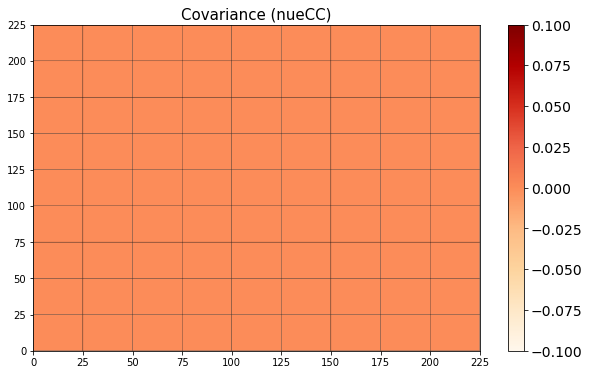

In [38]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['cov'], cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)




#plt.xlabel('Reco Shower Energy [GeV]', fontsize=15)
#plt.ylabel('Reco Shower Energy [GeV]', fontsize=15)

plt.title('Covariance (nueCC)', fontsize=15)

plt.show()

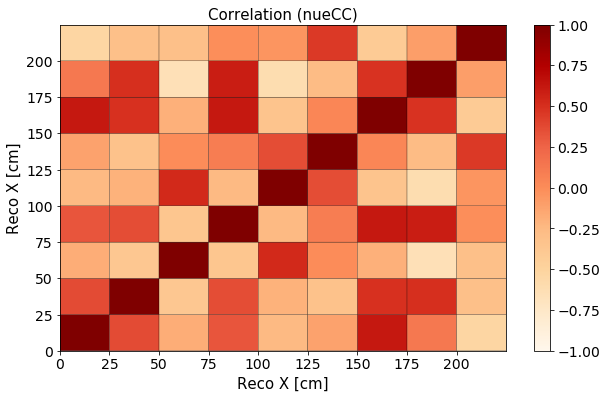

In [39]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(bins[:-1], fontsize=14)
plt.yticks(bins[:-1], fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Correlation (nueCC)', fontsize=15)

plt.show()

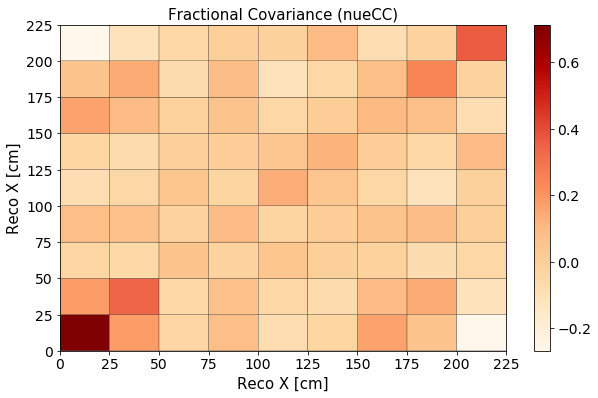

In [40]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Fractional Covariance (nueCC)', fontsize=15)

plt.show()

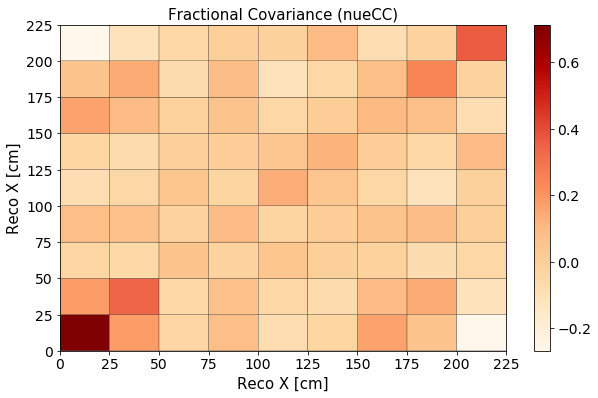

In [41]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel("Reco X [cm]", fontsize=15)
plt.ylabel("Reco X [cm]", fontsize=15)

plt.title('Fractional Covariance (nueCC)', fontsize=15)

plt.show()

/tmp/ipykernel_9528/4196610582.py:16: RuntimeWarning: invalid value encountered in double_scalars
  cv_cut_err = [np.sqrt(x)/x for x in cv_cut]


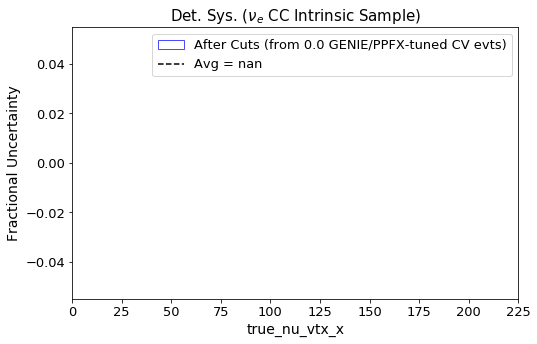

In [39]:

x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]


if isCombined == False:
    cv_cut = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune'])[0]
    plt.close()
elif isCombined == True:
    cv_cut = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune'])[0]
    plt.close()
    cv_cut += plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune'])[0]
    plt.close()

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]

plt.figure(figsize=(8, 5))

if isCombined == False:
    plt.errorbar(bin_centers, nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict['fractional_uncertainty']), 3)))
elif isCombined == True:
    plt.errorbar(bin_centers, nueCC_detsys_dict_comb['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict_comb['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), 3)))

    
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(xvar, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("Det. Sys. ($\\nu_{e}$ CC Intrinsic Sample)", fontsize=15)
#plt.savefig(parameters(ISRUN3)['plots_path']+"RHCRUN3DetSys.pdf", transparent=True, bbox_inches='tight') 

plt.show()

In [40]:
evolution_dict = {}

In [41]:
if isCombined == False:
    evolution_dict['nueCC_bdtcut'] = nueCC_detsys_dict['fractional_uncertainty']
elif isCombined == True:
    evolution_dict['nueCC_bdtcut'] = nueCC_detsys_dict_comb['fractional_uncertainty']
evolution_dict['nueCC_bdtcut_evts'] = round(sum(cv_cut),2)
evolution_dict['nueCC_bdtcut_err'] = cv_cut_err

Standard

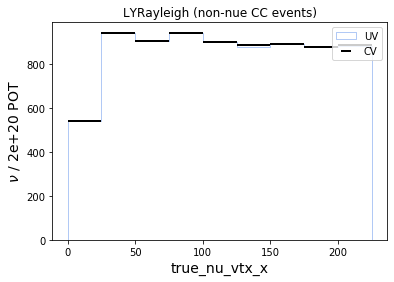

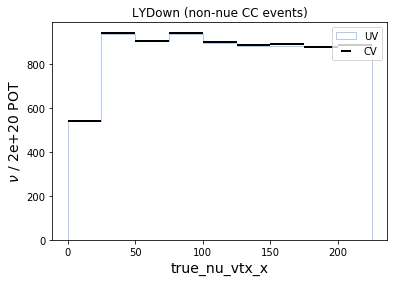

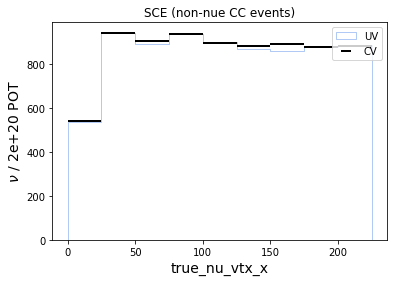

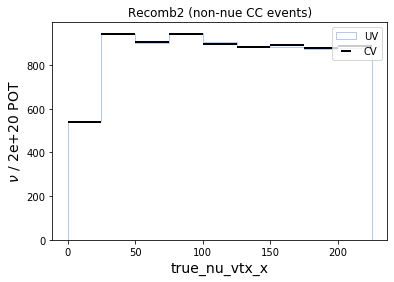

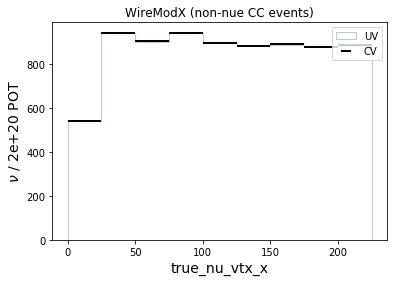

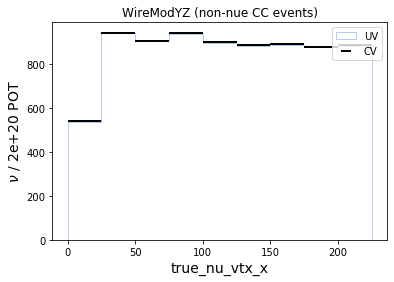

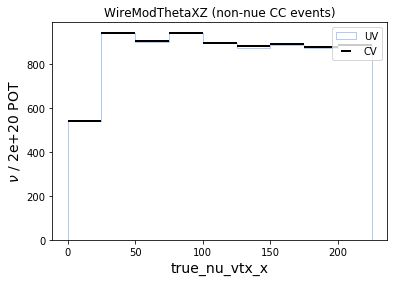

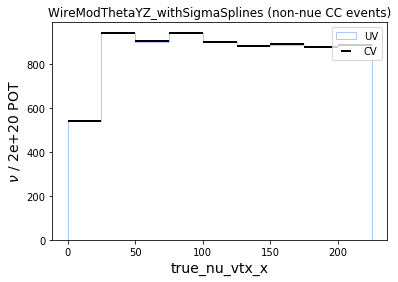

In [42]:
for variation in detvar_run1: 
    
    if variation=='CV': 
        continue
    
    plt.hist(bin_centers, bins, histtype='step', 
                        range=[bins[0], bins[-1]], weights=detvar_dict_run1[variation], 
                        color='cornflowerblue', linewidth=0.5, label='UV')
    
    plt.errorbar(bin_centers, detvar_dict_run1['CV'], 
                 xerr=x_err, fmt='none', color='black', linewidth=2, label='CV')
    plt.xlabel(xvar, fontsize=14)
    plt.ylabel('$\\nu$ / '+str(beamon_pot_run1)+' POT', fontsize=14)
    plt.title(variation+' (non-nue CC events)')
    plt.legend()
    plt.show()

In [43]:
if isCombined == False:
    detsys_cov_non_nueCC = {}


    for variation in detvar.keys(): 

        if variation=='CV': 
            continue

        # calc covariance for each unisim - fractional uncertainty WRT nonnueCC 
        detsys_cov_non_nueCC[variation] = calcCov(xvar, bins, detvar_dict['CV'], 
                                                  detvar_dict['CV'], 
                                                  [detvar_dict[variation]])
elif isCombined == True:
    detsys_cov_non_nueCC_run1 = {}
    detsys_cov_non_nueCC_run3 = {}
    
    for variation in detvar_run1.keys(): 

        if variation=='CV': 
            continue

        # calc covariance for each unisim - fractional uncertainty WRT nonnueCC 
        detsys_cov_non_nueCC_run1[variation] = calcCov(xvar, bins, detvar_dict_run1['CV']+detvar_dict_run1['CV_dirt'], 
                                                  detvar_dict_run1['CV'] +detvar_dict_run1['CV_dirt'], 
                                                  [detvar_dict_run1[variation]+detvar_dict_run1[variation+'_dirt']])
        
    run1_CV = detvar_dict_run1['CV']+detvar_dict_run1['CV_dirt']
    
    for variation in detvar_run3.keys(): 

        if variation=='CV': 
            continue

        # calc covariance for each unisim - fractional uncertainty WRT nonnueCC 
        detsys_cov_non_nueCC_run3[variation] = calcCov(xvar, bins, detvar_dict_run3['CV']+detvar_dict_run3['CV_dirt'], 
                                                  detvar_dict_run3['CV']+detvar_dict_run3['CV_dirt'], 
                                                  [detvar_dict_run3[variation]+detvar_dict_run3[variation+'_dirt']])
   
    run3_CV = detvar_dict_run3['CV']  +detvar_dict_run3['CV_dirt']                         

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [44]:
#  cov, corr, fractional uncertainty -- non nue CC

cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

if isCombined == False:
    for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] = sum([detsys_cov_non_nueCC[x]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
                frac_cov[i][j] = sum([detsys_cov_non_nueCC[x]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    non_nueCC_detsys_dict = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    } 
elif isCombined == True:
    
    comb_CV = np.array(run1_CV) + np.array(run3_CV)
    print(comb_CV)
    
    for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] = sum([detsys_cov_non_nueCC_run1[x]['cov'][i][j] for x in detvar_run1.keys() if x is not 'CV'])
                cov[i][j] += sum([detsys_cov_non_nueCC_run3[x]['cov'][i][j] for x in detvar_run3.keys() if x is not 'CV'])
                #frac_cov[i][j] = sum([detsys_cov_non_nueCC_run1[x]['frac_cov'][i][j] for x in detvar_run1.keys() if x is not 'CV'])
                #frac_cov[i][j] += sum([detsys_cov_non_nueCC_run3[x]['frac_cov'][i][j] for x in detvar_run3.keys() if x is not 'CV'])
                frac_cov[i][j] = cov[i][j]/(comb_CV[i]*comb_CV[j])
                
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    non_nueCC_detsys_dict_comb = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    }

[1724.7300627  3081.81789263 2944.62233649 3078.71914952 2869.45636784
 2923.78725401 2903.60839745 2965.92784882 2938.71386567 1293.54754703
 2311.36341947 2208.46675237 2309.03936214 2152.09227588 2192.84044051
 2177.70629809 2224.44588661 2204.03539926]


<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_9528/1845029815.py:11: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_non_nueCC[x]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_9528/1845029815.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_non_nueCC[x]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_9528/1845029815.py:34: SyntaxWarning: "is not" with a lit

In [45]:
non_nueCC_detsys_dict_comb['fractional_uncertainty']

array([0.05994404, 0.02101694, 0.02121492, 0.01968709, 0.02601784,
       0.03818344, 0.02123961, 0.03530876, 0.04819103])

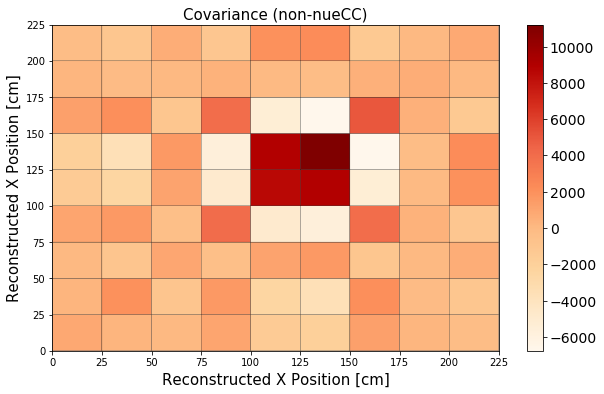

In [49]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, non_nueCC_detsys_dict_comb['cov'], cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)


plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)


plt.title('Covariance (non-nueCC)', fontsize=15)

plt.savefig("StandardOnly_Numu_Full_Detsys_TrueX_Cov.svg", bbox_inches='tight')

plt.show()

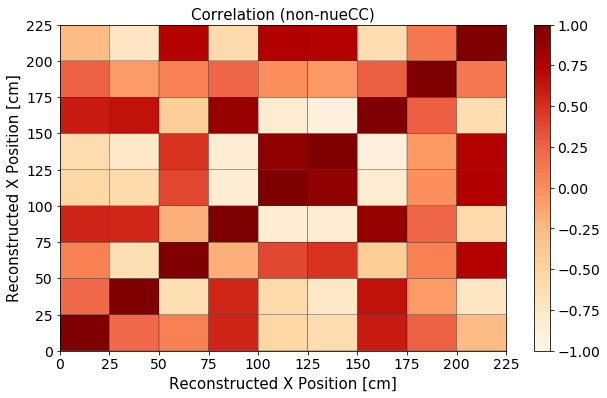

In [50]:
fig = plt.figure(figsize=(10, 6))

if isCombined == False:
    plt.pcolor(bins, bins, non_nueCC_detsys_dict['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
elif isCombined == True:
    plt.pcolor(bins, bins, non_nueCC_detsys_dict_comb['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)

plt.title('Correlation (non-nueCC)', fontsize=15)
plt.savefig("StandardOnly_Numu_Full_Detsys_TrueX_Cor.svg", bbox_inches='tight')

plt.show()

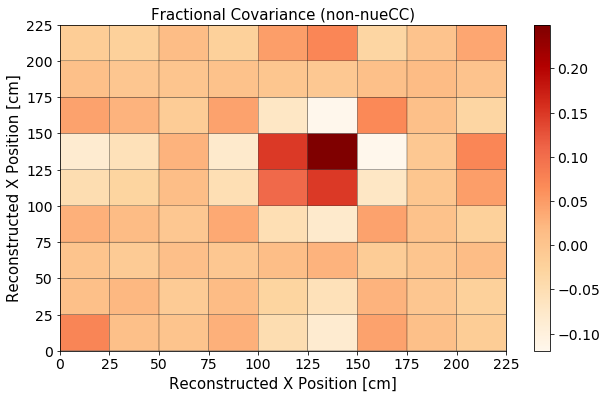

In [51]:
fig = plt.figure(figsize=(10, 6))

if isCombined == False:
    plt.pcolor(bins, bins, non_nueCC_detsys_dict['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
elif isCombined == True:
    plt.pcolor(bins, bins, non_nueCC_detsys_dict_comb['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)

plt.title('Fractional Covariance (non-nueCC)', fontsize=15)
plt.savefig("StandardOnly_Numu_Full_Detsys_TrueX_FracCov.svg", bbox_inches='tight')

plt.show()

In [46]:
detvar_dict_run1.keys()

dict_keys(['LYRayleigh', 'LYRayleigh_intrinsic', 'LYRayleigh_dirt', 'LYDown', 'LYDown_intrinsic', 'LYDown_dirt', 'SCE', 'SCE_intrinsic', 'SCE_dirt', 'Recomb2', 'Recomb2_intrinsic', 'Recomb2_dirt', 'WireModX', 'WireModX_intrinsic', 'WireModX_dirt', 'WireModYZ', 'WireModYZ_intrinsic', 'WireModYZ_dirt', 'WireModThetaXZ', 'WireModThetaXZ_intrinsic', 'WireModThetaXZ_dirt', 'WireModThetaYZ_withSigmaSplines', 'WireModThetaYZ_withSigmaSplines_intrinsic', 'WireModThetaYZ_withSigmaSplines_dirt', 'CV', 'CV_intrinsic', 'CV_dirt', 'cv_total_bkgd'])

[2048.47338867 3574.02709961 3436.53076172 3569.6640625  3410.48925781
 3354.40332031 3380.77148438 3332.4375     3361.79882812]

[2727.54882812 4800.43493652 4605.08361816 4794.95654297 4539.90722656
 4523.41601562 4534.23535156 4528.88134766 4538.23925781]


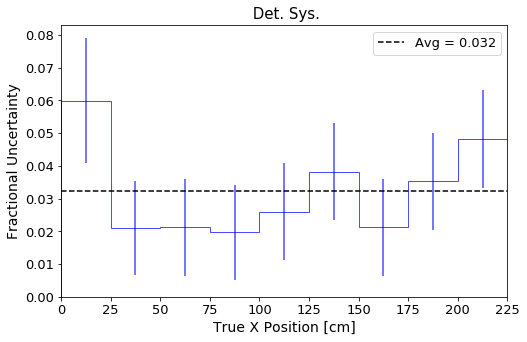

In [48]:

if isCombined == False:
    cv_cut = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune'])[0]
    plt.close()
elif isCombined == True:
    cv_cut = plt.hist(df_standard_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1['ppfx_cv']*df_standard_sel_run1['weightSplineTimesTune'])[0]
    print(cv_cut)
    print("")
    plt.close()
    cv_cut += plt.hist(df_standard_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3['ppfx_cv']*df_standard_sel_run3['weightSplineTimesTune'])[0]
    print(cv_cut)
    plt.close()
    
    np.savetxt("cv_cut_R1R3_numu.csv", 
               cv_cut,
               delimiter =", ", 
               fmt ='% s')

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]

plt.figure(figsize=(8, 5))

if isCombined == False:
    plt.errorbar(bin_centers, non_nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=non_nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
             label='After Cut (from '+str(round(sum(cv_cut),2))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(non_nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(non_nueCC_detsys_dict['fractional_uncertainty']), 3)))
elif isCombined == True:
    plt.errorbar(bin_centers, non_nueCC_detsys_dict_comb['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    #plt.hist(bin_centers, bins, weights=non_nueCC_detsys_dict_comb['fractional_uncertainty'], histtype='step', 
    #         label='After Cut (from '+str(round(sum(cv_cut),2))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)
    plt.hist(bin_centers, bins, weights=non_nueCC_detsys_dict_comb['fractional_uncertainty'], histtype='step', 
             color='blue',alpha=0.7)

    plt.hlines(np.average(non_nueCC_detsys_dict_comb['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(non_nueCC_detsys_dict_comb['fractional_uncertainty']), 3)))


plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title(" Det. Sys.", fontsize=15)
plt.savefig("StandardOnly_Numu_Full_Detsys_TrueX.svg", bbox_inches='tight')

plt.show()

In [56]:
if isCombined == False:
    evolution_dict['standard_bdtcut'] = non_nueCC_detsys_dict['fractional_uncertainty']
elif isCombined == True:
    evolution_dict['standard_bdtcut'] = non_nueCC_detsys_dict_comb['fractional_uncertainty']

evolution_dict['standard_bdtcut_evts'] = round(sum(cv_cut),2)
evolution_dict['standard_bdtcut_err'] = cv_cut_err

Evolution

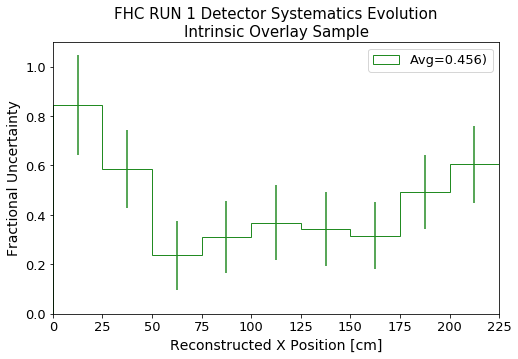

In [107]:
plt.figure(figsize=(8, 5))


# bdt cut
plt.hist(bin_centers, bins, weights=evolution_dict['nueCC_bdtcut'], histtype='step', color='forestgreen', 
        label='Avg='+str(round(np.average(evolution_dict['nueCC_bdtcut']),3))+')')
plt.errorbar(bin_centers, evolution_dict['nueCC_bdtcut'], fmt='none', yerr=evolution_dict['nueCC_bdtcut_err'], color='forestgreen')


plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.3)

plt.legend(fontsize=13)

plt.xlabel("Reconstructed X Position [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC RUN 1 Detector Systematics Evolution\nIntrinsic Overlay Sample", fontsize=15)

plt.show()

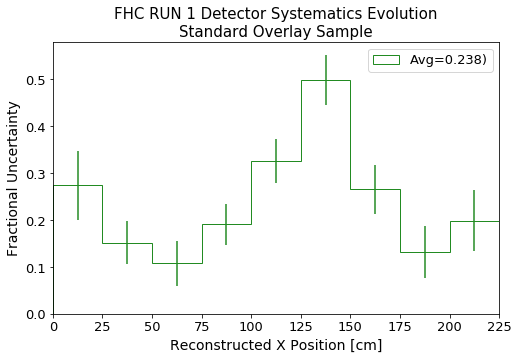

In [108]:
plt.figure(figsize=(8, 5))


# bdt cut
plt.hist(bin_centers, bins, weights=evolution_dict['standard_bdtcut'], histtype='step', color='forestgreen', 
        label='Avg='+str(round(np.average(evolution_dict['standard_bdtcut']),3))+')')
plt.errorbar(bin_centers, evolution_dict['standard_bdtcut'], fmt='none', yerr=evolution_dict['standard_bdtcut_err'], color='forestgreen')


plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 3.4)

plt.legend(fontsize=13)

plt.xlabel("Reconstructed X Position [cm]", fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC RUN 1 Detector Systematics Evolution\nStandard Overlay Sample", fontsize=15)


plt.show()

### Note

Both provides the lowest value of 14.9% uncertainty. The nue CC sample is a little odd, but not far enough to eliminate it.

11.5% if go to 225 only. 10.4% for Sept19.

3.2% for truth Sept19.

23.8% for updated no bkg subtract.